<a href="https://colab.research.google.com/github/tg-bomze/Style-Transfer-Collection/blob/master/(Video)_pytorch_AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">pytorch-AdaIN (VIDEO)</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [pytorch-AdaIN](https://github.com/naoto0804/pytorch-AdaIN)

Article: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868)

Creators: **[Naoto Inoue](https://github.com/naoto0804), [Xun Huang](https://github.com/xunhuang1995).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

!pip install numpy==1.17.2
!pip install Pillow==6.1.0
!pip install protobuf==3.9.1
!pip install six==1.12.0
!pip install tensorboardX==1.8
!pip install torch==1.2.0
!pip install torchvision==0.4.0
!pip install tqdm==4.35.0

<b><font color="red" size="+2">Before executing the next block, select "Runtime > Restart runtime" from the top of the menu.</font>

<b><font color="black" size="+1">(RUS) Перед выполнением следующего блока выберите сверху в меню "Среда выполнения > Перезапустить среду выполнения"</font>

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install other necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить прочие необходимые библиотеки</font></b>
import os
import io
import cv2
from PIL import Image
import imageio
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython import display as ipythondisplay
from IPython.display import Image as ipythonimage
%matplotlib inline

!git clone https://github.com/naoto0804/pytorch-AdaIN.git
%cd /content/pytorch-AdaIN

!mkdir models
%cd /content/pytorch-AdaIN/models
!gdown https://drive.google.com/uc?id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y
!gdown https://drive.google.com/uc?id=1w9r1NoYnn7tql1VYG3qDUzkbIks24RBQ
%cd /content/pytorch-AdaIN

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload video (content)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить видео (оригинал)</font></b>

!rm -rf video
!mkdir video
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one video at a time!')

vid = uploaded[0]
os.rename(vid, vid.replace(" ", ""))
vid = vid.replace(" ", "")
!mv -f $vid video/driving.mp4
vid = '/content/pytorch-AdaIN/video/driving.mp4'

fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))

Первый кадр:



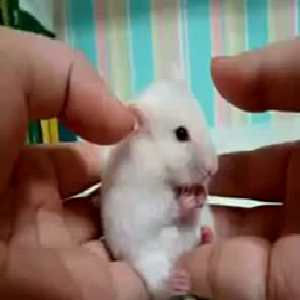

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Split video into frames</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Порезать видео на кадры</font></b>

!rm -rf frames
!mkdir frames

frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture(vid)
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

frames = []
fram = os.listdir("/content/pytorch-AdaIN/frames")
fram.sort()

fram_path = '/content/pytorch-AdaIN/frames/' + fram[0]
print("First frame:\n")
display(Image.open(fram_path).resize((300, 300)))

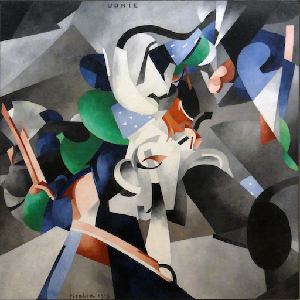

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload image (style)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото (стиль)</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
pic_name = "photo." + fn.split(".")[-1]
!mv -f $fn $pic_name

display(Image.open(pic_name).resize((300, 300)))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Style Transfer</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Перенести стиль из фото на видео</font></b>
%%time
!rm -rf stylized_frames
!mkdir stylized_frames

im = Image.open(fram_path)
(width, height) = im.size
min_size_cont = min(width, height)

im = Image.open(pic_name)
(width, height) = im.size
min_size_styl = min(width, height)

temp_path = '/content/pytorch-AdaIN/frames'
output_path = '/content/pytorch-AdaIN/stylized_frames'
!CUDA_VISIBLE_DEVICES=0 python test.py --content_dir $temp_path --style $pic_name --output $output_path --content_size $min_size_cont --style_size $min_size_styl
clear_output()

CPU times: user 42.7 ms, sys: 22.6 ms, total: 65.4 ms
Wall time: 15.3 s


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Join frames in a video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Собрать кадры в видео</font></b>
!ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f mp3 sound.mp3
staffs = []
img = os.listdir("/content/pytorch-AdaIN/stylized_frames")
img.sort()
for i in img:
  staffs.append("/content/pytorch-AdaIN/stylized_frames/"+i)

staff = cv2.imread(staffs[0])  # get size from the 1st frame
writer = cv2.VideoWriter(
    'stylized_video.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'),   # codec (*'DIVX', *'MP4V', *'FMP4', *'MJPG', *'XVID', *'MP4S')
    fps_of_video,  # fps
    (staff.shape[1], staff.shape[0]),  # width, height
    isColor=len(staff.shape) > 2)
for staff in map(cv2.imread, staffs):
    writer.write(staff)
writer.release()

dstvid = 'stylized_video.mp4'
tmpfile = dstvid.replace('.mp4', '-audio.mp4')
!ffmpeg -i sound.mp3 -i $dstvid $tmpfile
!rm -rf $dstvid
!mv -f $tmpfile $dstvid

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Open the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Открыть финальное видео</font></b>
display(mpy.ipython_display("/content/pytorch-AdaIN/stylized_video.mp4", height=400, autoplay=1, loop=1, maxduration=600))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать финальное видео</font></b>
files.download('/content/pytorch-AdaIN/stylized_video.mp4')